In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd.functional import jacobian
import tqdm
from tqdm import notebook
import random
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_default_device('cuda')

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [3]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''
    def G_gs(tensor):
        x = torch.squeeze(tensor)
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(x) for g in gs], 0)

    return G_gs

def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), torch.squeeze(x), create_graph = True, vectorize=True)

In [4]:
def rattle_step(x, v1, h, M, gs, e):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    M1 =  torch.inverse(M)

    G1 = G(gs)


    DV = torch.zeros_like(x)

    #DV[-1] = 10  # leaving this out for g-BAOAB
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    # doing Newton-Raphson iterations
    iters = 0
    x2 = x_col + h * v1_col - 0.5*(h**2)* M1 @ DV_col
    Q_col = x2
    Q = torch.squeeze(Q_col)
    J1 = J(gs, torch.squeeze(x_col))

    #print("RATTLE")
    #while torch.any(torch.abs(G1(Q)) > e):
    for iters in range(3):
        J2 = J(gs, torch.squeeze(Q))
        R = J2 @ M1 @ J1.t()
        dL = torch.inverse(R) @ G1(Q)
        #print(f"Q = {Q}")
        Q=Q- M1 @ J1.t() @ dL
    #print("CONVERGED")
    #print(f"Updating v1_col, Jacobian {J(gs,torch.squeeze(x_col))}")
    #print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t()}")

    # half step for velocity
    Q_col = Q.reshape(-1,1)
    v1_half = (Q_col - x_col)/h
    x_col = Q_col
    J1 = J(gs, torch.squeeze(x_col))

    # getting the level
    J2 = J(gs, torch.squeeze(Q))
    P = J1 @ M1 @ J1.t()
    T = J1 @ (2/h * v1_half - M1 @ DV_col)

    #solving the linear system
    L = torch.linalg.solve(P,T)

    v1_col = v1_half - h/2 * DV_col - h/2 * J2.t()@L


    # print(f"Error = {G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))}")
    # # updating v
    # print(f"lam = {lam}")
    # print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t}")

    return torch.squeeze(x_col), torch.squeeze(v1_col)

In [5]:
def gBAOAB_step_exact(q_init,p_init,F, gs, h,M, gamma, k, kr,e):
    # setting up variables
    M1 = torch.inverse(M)
    R = torch.randn(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h))
    b2 = torch.sqrt(k*(1-a2**(2)))

    # doing the initial p-update
    J1 = J(gs,torch.squeeze(q))
    G = J1
    L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1
    p =p-  h/2 * L1 @ F(q)


    # doing the first RATTLE step
    for i in range(kr):
      q, p = rattle_step(q, p, h/2*kr, M, gs, e)


    # the second p-update - (O-step in BAOAB)
    J2 = J(gs,torch.squeeze(q))
    G = J2
    L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1
    p = a2* p + b2* M**(1/2) @L2 @ M**(1/2) @ R

    # doing the second RATTLE step
    for i in range(kr):
      q, p = rattle_step(q, p, h/2*kr, M, gs, e)


    # the final p update
    J3= J(gs,torch.squeeze(q))
    G = J3
    L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1
    p = p-  h/2 * L3 @ F(q)

    return q,p

In [6]:
def gBAOAB_integrator(q_init,p_init,F, gs, h,M, gamma, k, steps,kr,e):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k,kr,e)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

In [7]:
def multi_gBAOAB_integrator(q_inits,p_inits,F, gs, h,M, gamma, k,ts,kr,e):
    positions = []
    velocities = []
    for ind in len(q_inits):
      q = q_inits[i]
      p = p_inits[i]
      steps = int(ts[i]//h)
      for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k,kr,e)
      positions.append(q)
      velocities.append(p)

    return torch.stack(positions), torch.stack(velocities)

In [8]:
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (11, 12),
    (12, 13),
    (13, 14),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [9]:
def length_constraint(i,j, xinit):
    init = torch.squeeze(xinit)
    def constraint_fn(y):
        x = torch.squeeze(y) # will need to change for batched data
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [10]:
def length_constraint_2(i, xinit):
    init = torch.squeeze(xinit)
    def constraint_fn(y):
        x = torch.squeeze(y)
        return (x[3*i]- 0)**2 +(x[3*i+1]- 0)**2 + (x[3*i+2]- 2)**2 - ((init[3*i]- 0)**2 +(init[3*i+1]- 0)**2 + (init[3*i+2]- 2)**2)
    return constraint_fn

In [11]:
def cotangent_projection(gs):
    def proj(x):
        G = J(gs,x)
        M = torch.eye(G.size()[1])
        L= torch.eye(G.size()[1]) - G.T @ torch.inverse(G @ M @ G.T) @ G @ torch.inverse(M)
        return L, G
    return proj

In [12]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=1/3):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * torch.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [13]:
class ScoreNet(nn.Module):
  """A time-dependent score-based model."""


  def __init__(self, embed_dim):
    super().__init__()
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),nn.Linear(embed_dim, embed_dim))
    self.lin_embed = nn.Linear(embed_dim,150)
    self.lin_embed2 = nn.Linear(embed_dim,150)
    self.lin1 = nn.Linear(57,150)
    #self.lin2 = nn.Linear(20, 20)
    self.lin3 = nn.Linear(150, 150)
    self.lin4 = nn.Linear(150, 57)
    self.lin5 = nn.Linear(57,57)
    self.act = torch.nn.Sigmoid()
    
  #@torch.compile(mode="default")
  def forward(self,x,t,L,G):
      # setting the fixed points of x
      l = torch.zeros_like(x)
      l[:,0] = x[:,0]
      l[:,1] = x[:,1]
      l[:,2] = -torch.ones_like(x[:,2])*2 + x[:,2]

      x = x - l
      embed = self.act(self.embed(t))
      h = self.lin1(x)
      h = h+ self.lin_embed(embed)
      #h = self.act(self.lin2(h))
      h = self.act(self.lin3(h))+ self.lin_embed2(embed)
      h = self.lin4(h)
      h = h+ self.act(self.lin5(x))

      # projection
      p = torch.unsqueeze(L@ torch.squeeze(h),0)
      h = p
    
      # testing that the cotangent projection works?????
      
      # NOT normalizing the output
      #h = h/ t[:,None]

      # setting the force on the fixed point to zero
      l2 = torch.zeros_like(h)
      l2[:,0] = h[:,0]
      l2[:,1] = h[:,1]
      l2[:,2] = h[:,2]
      h = h - l2
      #print(f"Projection error: {G@ torch.squeeze(h)}")
      return torch.squeeze(h)

In [14]:
score_model = torch.nn.DataParallel(ScoreNet(100))
score_model.train()

DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (lin_embed): Linear(in_features=100, out_features=150, bias=True)
    (lin_embed2): Linear(in_features=100, out_features=150, bias=True)
    (lin1): Linear(in_features=57, out_features=150, bias=True)
    (lin3): Linear(in_features=150, out_features=150, bias=True)
    (lin4): Linear(in_features=150, out_features=57, bias=True)
    (lin5): Linear(in_features=57, out_features=57, bias=True)
    (act): SiLU()
  )
)

In [15]:
# epoch_losses = np.load('epoch_losses_moredata.npy').tolist()
# test_losses = np.load('test_losses_moredata.npy').tolist()

In [16]:
from torch.utils.data import TensorDataset, DataLoader

In [17]:
from torch.optim import Adam

In [18]:
import warnings
warnings.filterwarnings("ignore")


In [19]:
#torch._dynamo.config.verbose=True

In [20]:
#torch._dynamo.config.suppress_errors = True

In [21]:
#data10 =np.load('1000-2000.npy',allow_pickle=True)

# Sampling from the reverse SDE

In [22]:
# data1 = np.load('0-100.npy',allow_pickle=True)
# data2 = np.load('100-200.npy',allow_pickle=True)
# data3 = np.load('200-250.npy',allow_pickle=True)
# data4 = np.load('250-400.npy',allow_pickle=True)
# data5 = np.load('400-500.npy',allow_pickle=True)
# data6 = np.load('500-600.npy',allow_pickle=True)
# data7= np.load('600-650.npy',allow_pickle=True)
# data8= np.load('650-700.npy',allow_pickle=True)
# data9= np.load('700-750.npy',allow_pickle=True)
# data10= np.load('750-800.npy',allow_pickle=True)

#data10 =np.load('t10_1000-2000.npy',allow_pickle=True)
data11= np.load('t10_2000-3000.npy',allow_pickle=True)
data12= np.load('t10_3000-4000.npy',allow_pickle=True)
data13= np.load('t10_0-1000.npy',allow_pickle=True)


In [23]:
data14= np.load('t10_7000-8000.npy',allow_pickle=True)

In [24]:
testdata = np.load('11000-11500.npy',allow_pickle=True)
testnumpy = np.array([np.array([data.numpy() for data in data_1]) for data_1 in testdata])
test_tensor = torch.tensor(testnumpy)
test_dataset = TensorDataset(test_tensor)

In [25]:
# numpy1 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data1])
# numpy2 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data2])
# numpy3 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data3])
# numpy4 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data4])
# numpy5 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data5])
# numpy6 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data6])
# numpy7 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data7])
# numpy8 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data8])
# numpy9 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data9])
numpy11 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data11])
numpy12 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data12])
numpy13 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data13])
numpy14 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data14])
# numpy15 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data15])
# #numpy16 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data16])
# numpy17 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data17])
# numpy18 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data18])
# numpy19 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data19])
# #numpy20 = np.array([np.array([data.numpy() for data in data_1]) for data_1 in data20])

In [26]:
data_numpy = np.concatenate([numpy11,numpy12,numpy13,numpy14])

In [27]:
print(len(data_numpy))

1381


In [28]:
data_tensor = torch.tensor(data_numpy, device = 'cpu')

In [29]:
my_dataset = TensorDataset(data_tensor[100:])
test_dataset = TensorDataset(data_tensor[:100])

In [30]:
#@title Define the loss function (double click to expand or collapse)
def loss2(model, xs,eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # uniformly selecting a time
  loss =torch.tensor([0.])
  loss.requires_grad_()
  tr =0
  s_tr = 0
  for x in xs:
    # x is the list of simulated qs
    q = torch.squeeze(x[0]).detach()
    gs = [length_constraint(i,j,torch.squeeze(q)) for (i,j) in bones2]
    gs.append(length_constraint_2(1,torch.squeeze(q)))
    gs.append(length_constraint_2(11,torch.squeeze(q)))
    gs.append(length_constraint_2(15,torch.squeeze(q)))

    # projection matrix
    L_fn = cotangent_projection(gs)
    #torch.manual_seed(0)
    random_t = torch.round(torch.rand(1, device=x.device)*(len(x))-1) +1
    q = x[random_t.cpu().numpy()-1]

    sim_x = q
    L , G= L_fn(sim_x) # defining the projection matrix
    score = model(sim_x, random_t/1000,L,G).to('cuda')
    
    # defining this so the jacobian ends up being correct :)
    def find_score(x,t):
        Lf,G = L_fn(x)
        L = Lf
        return model(x, t,L,G).to('cuda')
    
    loss = loss + (1/2 * torch.linalg.norm(score)**2 + torch.trace(torch.squeeze(torch.autograd.functional.jacobian(find_score, inputs=(sim_x,random_t/1000), create_graph=True,strict=False,vectorize=False,)[0])))
  return (loss/len(xs)) 

In [31]:
#torch._dynamo.config.suppress_errors = True

In [32]:
#torch.autograd.set_detect_anomaly(True)

In [33]:
epoch_losses =[]
test_losses = []

  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/161 [00:00<?, ?it/s]libibverbs: Warning: couldn't load driver '/usr/lib/libibverbs/libmlx4-rdmav34.so': /usr/lib/libibverbs/libmlx4-rdmav34.so: cannot open shared object file: No such file or directory

Loss = 1.1047993390055177:  63%|██████▎   | 101/161 [06:44<03:43,  3.72s/it]


Loss = 2.6971435797687606: 100%|██████████| 161/161 [10:43<00:00,  3.99s/it]


TEST DATA LOSS: -0.6311463264108081


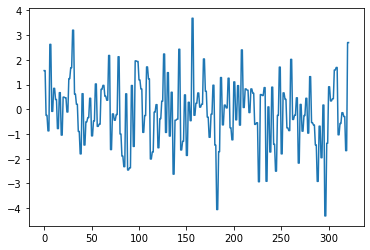


Loss = -1.1888655346449573:  63%|██████▎   | 102/161 [06:27<03:44,  3.81s/it]


Loss = 7.612085129698434: 100%|██████████| 161/161 [10:08<00:00,  3.78s/it]


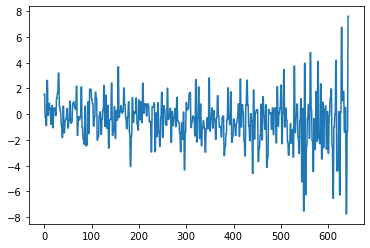


Loss = 3.6881546711999507:  63%|██████▎   | 102/161 [06:28<03:59,  4.05s/it]


Loss = -2.1744295714058355: 100%|██████████| 161/161 [10:08<00:00,  3.78s/it]


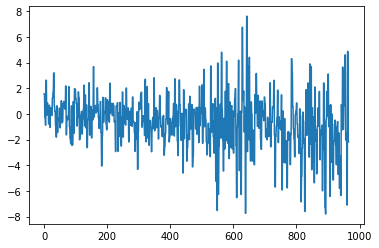


Loss = -6.007502134463315:  63%|██████▎   | 102/161 [06:19<04:36,  4.69s/it]


Loss = -1.3588051829762056: 100%|██████████| 161/161 [09:47<00:00,  3.65s/it]


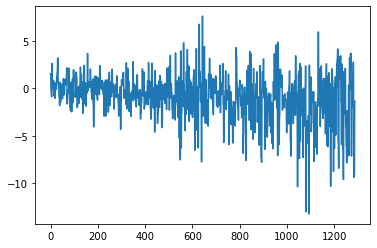


Loss = -2.9505105916267187:  63%|██████▎   | 102/161 [06:06<03:47,  3.86s/it]


Loss = 8.114184404789683: 100%|██████████| 161/161 [09:39<00:00,  3.60s/it]


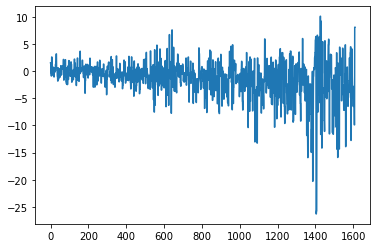


Loss = -5.312393002700765:  64%|██████▍   | 103/161 [06:03<03:26,  3.56s/it]


Loss = -5.9360479588960375: 100%|██████████| 161/161 [09:28<00:00,  3.53s/it]


TEST DATA LOSS: -1.2996606091975047


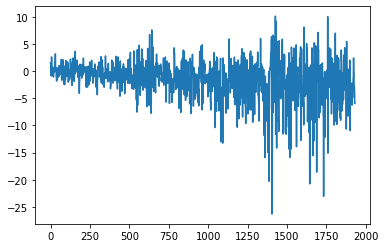


Loss = -11.814419087621696:  63%|██████▎   | 102/161 [06:19<03:43,  3.79s/it]


Loss = 10.093410280075457: 100%|██████████| 161/161 [09:54<00:00,  3.69s/it]


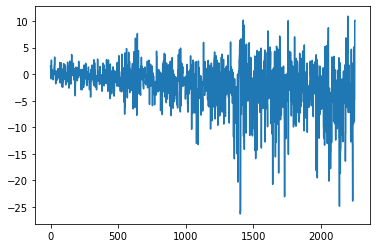


Loss = -3.8412033826380707:  63%|██████▎   | 102/161 [06:28<03:52,  3.95s/it]


Loss = -19.316711313481157: 100%|██████████| 161/161 [10:15<00:00,  3.82s/it]


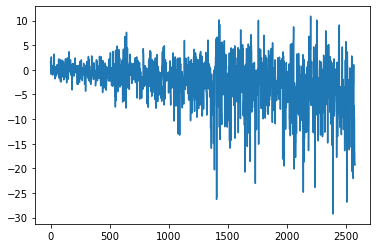


Loss = -6.226384617890581:  63%|██████▎   | 102/161 [06:17<03:47,  3.86s/it]


Loss = 3.0954595078903044: 100%|██████████| 161/161 [10:02<00:00,  3.74s/it]


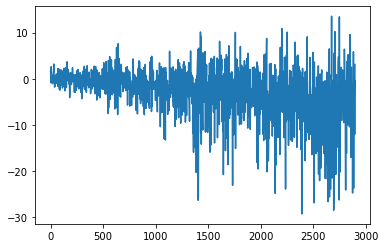


Loss = -2.818658273726106:  63%|██████▎   | 102/161 [06:41<03:49,  3.89s/it]


Loss = 7.852692843663924: 100%|██████████| 161/161 [10:24<00:00,  3.88s/it]


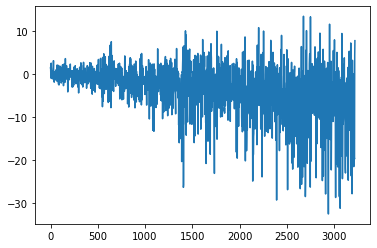


Loss = -6.038163349390826:  63%|██████▎   | 102/161 [06:43<03:48,  3.87s/it]


Loss = 4.052642394027282: 100%|██████████| 161/161 [10:24<00:00,  3.88s/it]


TEST DATA LOSS: -8.399768871205719


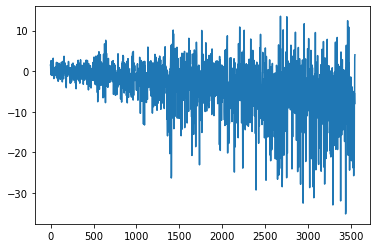


Loss = 5.861026642896549:  63%|██████▎   | 102/161 [06:17<03:37,  3.69s/it] 


Loss = 5.000071031114413: 100%|██████████| 161/161 [09:48<00:00,  3.65s/it]


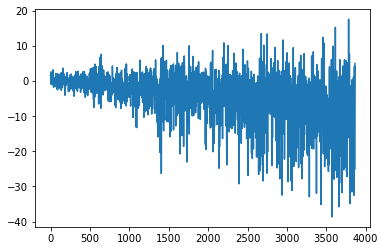


Loss = -1.4073132878483066:  63%|██████▎   | 102/161 [06:06<03:32,  3.61s/it]


Loss = -0.8102550163496556: 100%|██████████| 161/161 [09:32<00:00,  3.56s/it]


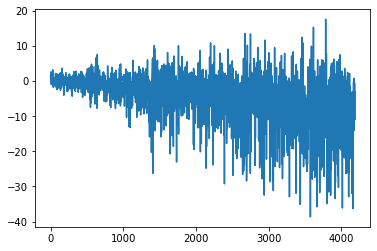


Loss = -6.309185280642209:  63%|██████▎   | 102/161 [06:11<03:37,  3.69s/it]


Loss = -62.65363784337325: 100%|██████████| 161/161 [09:49<00:00,  3.66s/it]


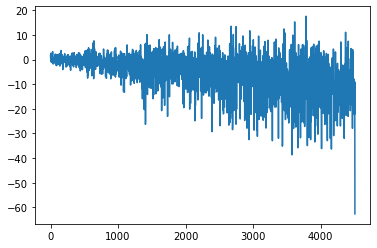


Loss = -18.701309017461593:  63%|██████▎   | 102/161 [06:19<03:33,  3.63s/it]


Loss = 12.36472911469636: 100%|██████████| 161/161 [10:00<00:00,  3.73s/it]


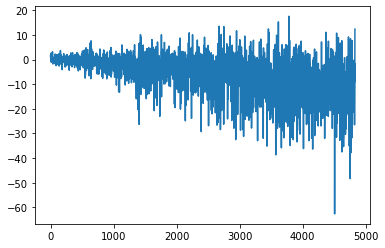


Loss = -24.72597623919038:  63%|██████▎   | 102/161 [06:38<03:59,  4.07s/it]


Loss = -41.35786389319707: 100%|██████████| 161/161 [10:35<00:00,  3.95s/it]


TEST DATA LOSS: -13.832880902450794


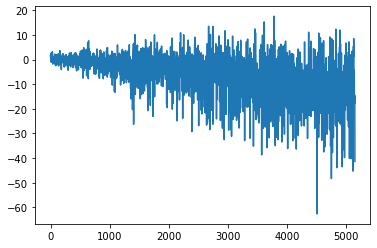


Loss = 3.5626142314589924:  63%|██████▎   | 102/161 [07:30<04:23,  4.46s/it]


Loss = -4.405692248785778: 100%|██████████| 161/161 [11:50<00:00,  4.42s/it]


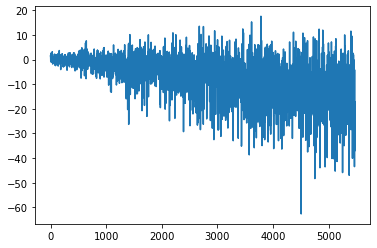


Loss = -9.589987225320733:  63%|██████▎   | 102/161 [07:31<04:16,  4.35s/it] 


Loss = -26.31278520851277: 100%|██████████| 161/161 [12:26<00:00,  4.64s/it]


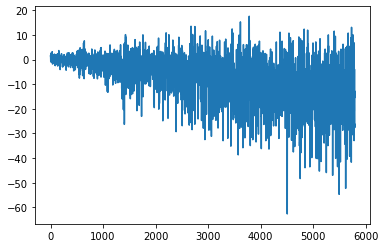


Loss = -14.49887819501139:  63%|██████▎   | 102/161 [09:09<05:14,  5.33s/it] 


Loss = -19.83261743195726: 100%|██████████| 161/161 [14:17<00:00,  5.32s/it]


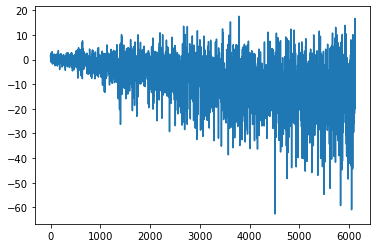


Loss = -30.572737265901765:  63%|██████▎   | 102/161 [08:51<04:43,  4.80s/it]


Loss = -33.18823214360208: 100%|██████████| 161/161 [13:46<00:00,  5.14s/it]


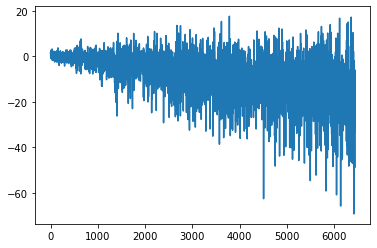


Loss = -1.7491060032963694:  63%|██████▎   | 102/161 [08:27<04:46,  4.86s/it]


Loss = -3.177956621796457: 100%|██████████| 161/161 [13:09<00:00,  4.91s/it]


TEST DATA LOSS: -15.032485728981326


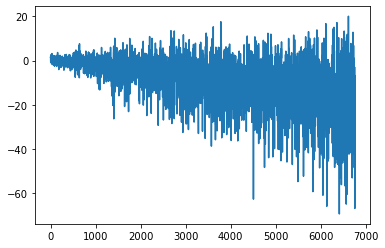


Loss = -17.72702514820829:  64%|██████▍   | 103/161 [08:49<05:02,  5.21s/it]


Loss = -1.7977227810878134: 100%|██████████| 161/161 [13:50<00:00,  5.16s/it]


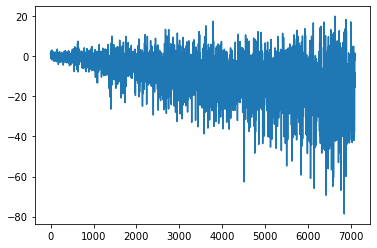


Loss = -35.8441077548099:  52%|█████▏    | 84/161 [06:35<05:10,  4.03s/it]

In [ ]:
## size of a mini-batch
## learning rate
lr=1e-4 #@param {'type':'number'}
batch_size =  8 #@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True,generator=torch.Generator(device='cuda'))
testloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False,generator=torch.Generator(device='cuda'))
n_epochs = 100
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)


for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    score_model.train()
    for pw in t_dl:
        x = pw[0].to('cuda')

        loss = loss2(score_model, x)
        t_dl.set_description(f"Loss = {loss.item()}")
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         for name, param in score_model.state_dict().items():
#             print(name, param.grad)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(loss.item())
    score_model.eval()
    #Checking on the test dataset
    if epoch%5 ==0:
        tot = 0
        i = 0
        for pw in testloader:
            x = pw[0].to('cuda')
            loss = loss2(score_model, x)
            tot += loss.item()
            i+=1
        print(f"TEST DATA LOSS: {tot/i}")
        test_losses.append(tot/i)
        np.save('test_losses_moredata', np.array(test_losses))
    np.save('epoch_losses_moredata', np.array(epoch_losses))
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), f"ckpt_best{epoch}.pth")

In [ ]:
## size of a mini-batch
## learning rate
lr=1e-4 #@param {'type':'number'}
batch_size =  32 #@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True,generator=torch.Generator(device='cuda'))
testloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False,generator=torch.Generator(device='cuda'))
n_epochs = 50
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)

for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    score_model.train()
    for pw in t_dl:
        x = pw[0].to('cuda')

        loss = loss2(score_model, x)
        t_dl.set_description(f"Loss = {loss.item()}")
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         for name, param in score_model.state_dict().items():
#             print(name, param.grad)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(loss.item())
    score_model.eval()
    #Checking on the test dataset
    tot = 0
    i = 0
    for pw in testloader:
        x = pw[0].to('cuda')
        loss = loss2(score_model, x)
        tot += loss.item()
        i+=1
    print(f"TEST DATA LOSS: {tot/i}")
    
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), f"ckpt_SCALED{epoch}.pth")

In [ ]:
# note - it would be good to beat -5

In [ ]:
plt.plot(epoch_losses)

In [ ]:
np.save('run3.npy', np.array(epoch_losses))

In [ ]:
## size of a mini-batch
## learning rate
lr=1e-4 #@param {'type':'number'}
batch_size =  32 #@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True,generator=torch.Generator(device='cuda'))
testloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False,generator=torch.Generator(device='cuda'))
n_epochs = 50
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)

for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    score_model.train()
    for pw in t_dl:
        x = pw[0].to('cuda')

        loss = loss2(score_model, x)
        t_dl.set_description(f"Loss = {loss.item()}")
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         for name, param in score_model.state_dict().items():
#             print(name, param.grad)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(loss.item())
    score_model.eval()
    #Checking on the test dataset
    tot = 0
    i = 0
    for pw in testloader:
        x = pw[0].to('cuda')
        loss = loss2(score_model, x)
        tot += loss.item()
        i+=1
    print(f"TEST DATA LOSS: {tot/i}")
    
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), f"ckpt_SCALED{epoch+73}.pth")

In [ ]:
x = torch.rand(57)
x.requires_grad_()

# generating a uniform position

In [ ]:
data = np.load('train_dataset.npy')

In [ ]:
bones = [
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [ ]:
def angles_to_joints(angles, lengths,bones):
    pose = torch.zeros((19,3))
    pose[0] = torch.tensor([0,0,2])
    for i in range(len(bones)):
        bone = bones[i]
        r = lengths[i]
        phi = torch.tensor(angles[i][0])
        theta = torch.tensor(angles[i][1])
        pose[bone[1]] = pose[bone[0]] + torch.tensor([r*torch.sin(theta)*torch.cos(phi),r*torch.sin(theta)*torch.sin(phi),r*torch.cos(theta)])
    return pose

In [ ]:
def lengths(bones,poses):
    lengths = []
    poses = torch.squeeze(poses).reshape((19,3))
    for bone in bones:
        l = poses[bone[0]] -poses[bone[1]]
        l = torch.sqrt(torch.dot(l,l))
        lengths.append(l)
    return lengths

In [ ]:
def uniform_generator(x_init,bones):
    random_angles = torch.vstack([torch.rand(18)*torch.pi*2,torch.acos(2*torch.rand(18) -1)]).T
    lengths1 = lengths(bones, x_init)
    return angles_to_joints(random_angles,lengths1,bones)

since the original SDE was just Brownian motion, the reverse is simply:

In [ ]:
data = np.load('train_dataset.npy')
x_init = torch.squeeze(torch.tensor(data[0]))

In [ ]:
#ckpt = torch.load('ckpt.pth')
score_model.load_state_dict(ckpt)

In [ ]:
q_init = uniform_generator(torch.squeeze(x_init),bones)

In [ ]:
torch._dynamo.config.suppress_errors = True

In [ ]:
@torch.compile(mode = "max-autotune")
def run_simulation(q_init,steps):
  h = 1/steps
  positions = []
  q = torch.flatten(torch.squeeze(q_init))
  gs = [length_constraint(i,j,torch.squeeze(q)) for (i,j) in bones2]
  gs.append(length_constraint_2(1,torch.squeeze(q)))
  gs.append(length_constraint_2(11,torch.squeeze(q)))
  gs.append(length_constraint_2(15,torch.squeeze(q)))
  p = torch.zeros_like(q)
  M = torch.eye(q.size()[0])
  L_fn = cotangent_projection(gs)
  @torch.compile()
  def force(y):
    with torch.no_grad():
      x = torch.unsqueeze(y,0)
      L = L_fn(x)
      score = -score_model(x,time,L)
    return torch.squeeze(score)
  for step in range(1,steps):
      print(step)
      time = torch.tensor([1-(step)*h])
      q1 = q
      q, p = gBAOAB_step_exact(q,p,force, gs, h,M, 1,1,1,10**(-11))
      print(f"Movement of q: {torch.linalg.norm(q-q1)}")
      positions.append(q)
  return positions

In [ ]:
positions = run_simulation(q_init, 10000)

In [ ]:
pos = np.array([p.detach() for p in positions])
np.save('reverse_pos_new.npy',pos)